<a href="https://colab.research.google.com/github/brighamfrandsen/econ484/blob/master/examples/datasciencepanel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning and Economics:
# Estimating Heterogeneous Causal Effects


In [1]:
# Connect to github repo
!git clone https://github.com/Mixtape-Sessions/Heterogeneous-Effects.git
%cd Heterogeneous-Effects/Labs

Cloning into 'Heterogeneous-Effects'...
remote: Enumerating objects: 162, done.
remote: Counting objects: 100% (162/162), done.
remote: Compressing objects: 100% (112/112), done.
remote: Total 162 (delta 62), reused 146 (delta 46), pack-reused 0 (from 0)
Receiving objects: 100% (162/162), 26.23 MiB | 11.72 MiB/s, done.
Resolving deltas: 100% (62/62), done.
/content/Heterogeneous-Effects/Labs


In [2]:
# import useful packages
import pandas as pd  # for loading and managing datasets
import statsmodels.api as sm  # for running regressions and getting standard errors

In [3]:
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('seaborn-v0_8-whitegrid')
from sklearn.tree import plot_tree

# Traditional regression-based heterogeneous treatment effects

Let's say we want to the know whether a job training program actually helps participants find a job. We can get data on $n$ people, some of whom participated ($Z_i=1$), and some of whom didn't ($Z_i=0$), as well their characteristics ($X_i$) and an indicator for if they found a job ($Y_i=1$) or not ($Y_i=0$).

Regression model for overall average effect:
$$Y_i = \beta_0 +\delta Z_i +\varepsilon_i$$

What if we wanted to see how the effects differed among men and women?
$$Y_i =\beta_0+\delta Z_i +\gamma Z_i \times Male_i +\beta_1 Male_i+\varepsilon_i $$

Or, more generally, given any vector of characteristics:
$$Y_i=\delta Z_i +Z_i\times X_i'\gamma+X_i'\beta+\varepsilon_i$$
$$\delta\left(x\right)=\delta+x'\gamma$$

Problems with traditional regression approach:


*   relationship with $X_i$ may be nonlinear
*   $X_i$ may be high dimensional

These are problems ML was born to solve!



# Using Machine Learning to Predict Heterogeneous Treatment Effects


## Random Causal Forest


In [4]:
# Install econml
%pip install econml #&> /dev/null

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 46.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 41.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.4/259.4 kB 14.0 MB/s eta 0:00:00
  Attempting uninstall: shap
    Found existing installation: shap 0.50.0
    Uninstalling shap-0.50.0:
      Successfully uninstalled shap-0.50.0


In [5]:
from econml.dml import CausalForestDML as CausalForest

## Random Causal Forest: Predict the effects of job training


We are ready to apply machine learning to predict causal effects in a real-life setting: how do the effects of job training vary by an individual's characteristics? We will use data from the National Job Training Partnership study, a large-scale randomized evaluation of a publicly subsidized job training program for disadvantaged youth and young adults. Why would we care how the effects of a subsidized job training program vary by a person's characteristics?


We will use the JTPA evaluation dataset, which contains observations on about 14,000 individuals, some of whom were randomized to participate in job training ($Z_i = 1$) and others who were not ($Z_i = 0$).

Plan:

- load the dataset from the `data/jtpahet.csv`
- define the outcome vector (call it `y`) to be the column labeled `foundjob`
- define the randomized assignment indicator (call it `Z`) to be the column labeled `z`
- define the feature vector (call it `x`) to be all columns except `foundjob`, `z`, and `enroll`.


In [6]:
data = pd.read_csv(
    "data/jtpahet.csv"
)
data

,age,enroll,priorearn,educ,female,nonwhite,z,married,foundjob
0,46,1,0,12,1,1,1,0,1
1,24,1,3591,11,1,0,1,0,1
2,28,1,6000,9,0,1,1,1,1
3,23,0,2000,11,0,0,0,1,1
4,34,0,0,12,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...
13848,26,0,0,12,1,1,0,1,0
13849,52,0,0,10,0,0,1,0,0
13850,32,0,0,12,1,1,0,0,0
13851,16,1,0,9,0,1,1,0,0


In [7]:
y = data["foundjob"]
z = data["z"]
x = data.drop(["foundjob", "z", "enroll"], axis=1)
x

,age,priorearn,educ,female,nonwhite,married
0,46,0,12,1,1,0
1,24,3591,11,1,0,0
2,28,6000,9,0,1,1
3,23,2000,11,0,0,1
4,34,0,12,1,1,1
...,...,...,...,...,...,...
13848,26,0,12,1,1,1
13849,52,0,10,0,0,0
13850,32,0,12,1,1,0
13851,16,0,9,0,1,0


### Set up random forest


So far, so good? Now create a random causal forest object, and fit it with outcome `y`, treatment variable `z`, and feature matrix `x`.


In [8]:
rcf = CausalForest(n_estimators=500, discrete_treatment=True, criterion="het").fit(
    y, z, X=x
)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

### Explore effects


Let's see what kind of heterogeneous effects our random causal forest predicted


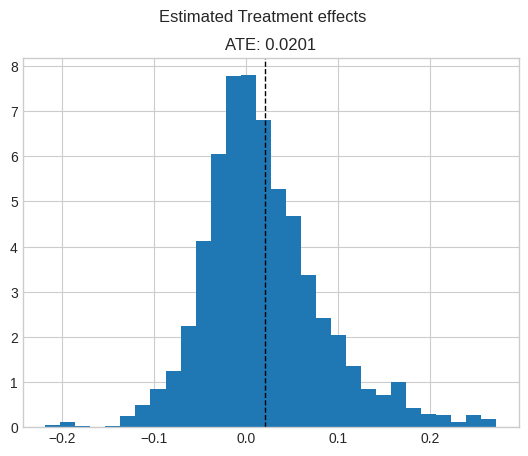

In [9]:
# calculate the predicted effects:
insamplefx = rcf.effect(x)
# plot a histogram of the estimated effects, with average effect overlaid
fig = plt.figure()
ax = plt.axes()
ax.hist(insamplefx, bins=30, density=True)
plt.axvline(rcf.ate_, color="k", linestyle="dashed", linewidth=1)
plt.suptitle("Estimated Treatment effects")
plt.title("ATE: {:.3g}".format(rcf.ate_[0]))
plt.show()

Let's visualize how these effects vary by prior earnings and education by making a heatmap


In [10]:
import itertools

In [11]:
# create a grid of values for education and prior earnings:
educgrid = np.arange(data["educ"].values.min(), data["educ"].values.max() + 1)
earngrid = np.arange(
    data["priorearn"].values.min(), data["priorearn"].values.max(), 5000
)
grid = pd.DataFrame(
    itertools.product(educgrid, earngrid), columns=["educ", "priorearn"]
)

NameError: name 'np' is not defined

We'll first visualize the effects among married, nonwhite females of average age:


In [ ]:
grid["age"] = data["age"].values.mean()  # set age to the average
grid["female"] = 1  # set female = 1
grid["nonwhite"] = 1  # set nonwhite = 1
grid["married"] = 1  # set married = 1
# need to re-order the columns to match x:
grid=grid[x.columns]


In [ ]:
gridfx = rcf.effect(grid)

### Visualize effects with a heatmap:


In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure()
ax = plt.subplot()
main = ax.scatter(
    grid["educ"], grid["priorearn"], c=gridfx, cmap="plasma", marker="s", s=300
)
plt.suptitle("Estimated Treatment effects")
plt.title("Nonwhite married females")
plt.xlabel("years of education")
plt.ylabel("prior earnings")

# create an Axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(main, cax=cax)
plt.show()